# Reinplementation of Block Coordinate Descent (BCD) Algorithm for Training DNNs (10-layer MLP) for MNIST in PyTorch

## Import libraries

In [1]:
"""
5 runs, seed = 5, 10, 15, 8, 19; 
validation accuracies: 0.8721, 0.8695, 0.8564, 0.8713, 0.8617
"""
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
%matplotlib inline

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.0.0
Torchvision Version: 0.2.1
GPU is available? True


## Read in MNIST dataset

In [2]:
dtype = torch.float
# device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Uncomment this to run on GPU

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

## Data manipulation

In [3]:
# Manipulate train set
x_d0 = mnist_trainset[0][0].size()[0]
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N, x_d0*x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
     x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1, x_d0*x_d1*x_d2))
     y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train, (N, 1)), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)
y_train = y_train.to(device=device)

# Manipulate test set
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((N_test, x_d0*x_d1*x_d2), device=device)
y_test = torch.empty(N_test, dtype=torch.long)
for i in range(N_test): 
     x_test[i,:] = torch.reshape(mnist_testset[i][0], (1, x_d0*x_d1*x_d2))
     y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test, (N_test, 1)), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)
y_test = y_test.to(device=device)

## Main algorithm (Jinshan's Algorithm in Zeng et al. (2018))

### Define parameter initialization and forward pass

In [4]:
# Initialization of parameters
torch.manual_seed(15)
def initialize(dim_in, dim_out):
    W = 0.01*torch.randn(dim_out, dim_in, device=device)
    b = 0.1*torch.ones(dim_out, 1, device=device)
    return W, b

# Forward pass
def feed_forward(weight, bias, activation, dim = N):
    U = torch.addmm(bias.repeat(1, dim), weight, activation)
    V = nn.ReLU()(U)
    return U, V

### Define functions for updating blocks

In [5]:
def updateV_js(U1,U2,W,b,rho,gamma): 
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W)) + gamma*I), \
                     rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2)) + gamma*U1)
    return Vstar

In [6]:
def updateWb_js(U, V, W, b, alpha, rho): 
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W + rho*torch.mm(U - b.repeat(1,col_U),torch.t(V)),\
                     torch.inverse(alpha*I + rho*(torch.mm(V,torch.t(V)))))
    bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N + alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [7]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Define hyperparameters

In [8]:
gamma = 1
# gamma1 = gamma2 = gamma3 = gamma4 = gamma5 = gamma6 \
# = gamma7 = gamma8 = gamma9 = gamma10 = gamma11 = gamma

rho = 1
# rho1 = rho2 = rho3 = rho4 = rho5 = rho6 = rho7 = rho8 
# = rho9 = rho10 = rho11 = rho 


alpha = 1
# alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
# = alpha8 = alpha9 = alpha10 = alpha

### Define block update

In [9]:
def block_update(Wn, bn, Wn_1, bn_1, Vn, Un, Vn_1, Un_1, Vn_2, dn_1, alpha = alpha, gamma = gamma, rho = rho, dim = N):
    # update W(n) and b(n)
    Wn, bn = updateWb_js(Un, Vn_1, Wn, bn, alpha, rho)
    # update V(n-1)
    Vn_1 = updateV_js(Un_1, Un, Wn, bn, rho, gamma)
    # update U(n-1)
    Un_1 = relu_prox(Vn_1, (rho*torch.addmm(bn_1.repeat(1,dim), Wn_1, Vn_2) + \
                            alpha*Un_1)/(rho + alpha), (rho + alpha)/gamma, dn_1, dim)
    return Wn, bn, Vn_1, Un_1

### Define loss computation of layers

In [10]:
def compute_loss(weight, bias, activation, preactivation, rho = rho):
    loss = rho/2 * torch.pow(torch.dist(torch.addmm(bias.repeat(1,N), weight, activation), preactivation, 2), 2).cpu().numpy()
    return loss

### Parameter initialization

In [11]:
# Layers: input + 3 hidden + output
d0 = x_d0*x_d1*x_d2
d1 = d2 = d3 = d4 = d5 = d6 \
= d7 = d8 = d9 = d10 = 600
d11 = K 


W1, b1 = initialize(d0, d1)
W2, b2 = initialize(d1, d2)
W3, b3 = initialize(d2, d3)
W4, b4 = initialize(d3, d4)
W5, b5 = initialize(d4, d5)
W6, b6 = initialize(d5, d6)
W7, b7 = initialize(d6, d7)
W8, b8 = initialize(d7, d8)
W9, b9 = initialize(d8, d9)
W10, b10 = initialize(d9, d10)
W11, b11 = initialize(d10, d11)


U1, V1 = feed_forward(W1, b1, x_train)
U2, V2 = feed_forward(W2, b2, V1)
U3, V3 = feed_forward(W3, b3, V2)
# U4 = torch.addmm(b4.repeat(1, N), W4, V3)
# V4 = U4
U4, V4 = feed_forward(W4, b4, V3)
U5, V5 = feed_forward(W5, b5, V4)
U6, V6 = feed_forward(W6, b6, V5)
U7, V7 = feed_forward(W7, b7, V6)
U8, V8 = feed_forward(W8, b8, V7)
U9, V9 = feed_forward(W9, b9, V8)
U10, V10 = feed_forward(W10, b10, V9)
U11 = torch.addmm(b11.repeat(1, N), W11, V10)
V11 = U11

niter = 300
loss1 = np.empty(niter)
loss2 = np.empty(niter)
layer1 = np.empty(niter)
layer2 = np.empty(niter)
layer3 = np.empty(niter)
layer4 = np.empty(niter)
layer5 = np.empty(niter)
layer6 = np.empty(niter)
layer7 = np.empty(niter)
layer8 = np.empty(niter)
layer9 = np.empty(niter)
layer10 = np.empty(niter)
layer11 = np.empty(niter)
layer11 = np.empty(niter)
layer21 = np.empty(niter)
layer31 = np.empty(niter)
layer41 = np.empty(niter)
layer51 = np.empty(niter)
layer61 = np.empty(niter)
layer71 = np.empty(niter)
layer81 = np.empty(niter)
layer91 = np.empty(niter)
layer101 = np.empty(niter)
layer111 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)

### Training algorithm

In [12]:
# Iterations
print('Train on', N, 'samples, validate on', N_test, 'samples')
for k in range(niter):
    start = time.time()
    
    W01, W02, W03, W04, W05, W06, W07, W08, W09, W010, W011 = W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11
    b01, b02, b03, b04, b05, b06, b07, b08, b09, b010, b011 = b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11
    
    '''
    # update V4
    V4 = (y_one_hot + gamma*U4 + alpha*V4)/(1 + gamma + alpha)
    
    # update U4 
    U4 = (gamma*V4 + rho*(torch.mm(W4,V3) + b4.repeat(1,N)))/(gamma + rho)
    '''
    # update V11
    V11 = (y_one_hot + gamma*U11 + alpha*V11)/(1 + gamma + alpha)
    
    # update U11
    U11 = (gamma*V11 + rho*(torch.mm(W11, V10) + b11.repeat(1,N)))/(gamma + rho)
    
    # update W11, b11, V10 and U10
    W11, b11, V10, U10 = block_update(W11, b11, W10, b10, V11, U11, V10, U10, V9, d10)
    
    # update W10, b10, V9 and U9
    W10, b10, V9, U9 = block_update(W10, b10, W9, b9, V10, U10, V9, U9, V8, d9)
    
    # update W9, b9, V8 and U8
    W9, b9, V8, U8 = block_update(W9, b9, W8, b8, V9, U9, V8, U8, V7, d8)
    
    # update W8, b8, V7 and U7
    W8, b8, V7, U7 = block_update(W8, b8, W7, b7, V8, U8, V7, U7, V6, d7)
    
    # update W7, b7, V6 and U6
    W7, b7, V6, U6 = block_update(W7, b7, W6, b6, V7, U7, V6, U6, V5, d6)
    
    # update W6, b6, V5 and U5
    W6, b6, V5, U5 = block_update(W6, b6, W5, b5, V6, U6, V5, U5, V4, d5)
    
    # update W5, b5, V4 and U4
    W5, b5, V4, U4 = block_update(W5, b5, W4, b4, V5, U5, V4, U4, V3, d4)
    
    # update W4, b4, V3 and U3
    W4, b4, V3, U3 = block_update(W4, b4, W3, b3, V4, U4, V3, U3, V2, d3)
    
    # update W3, b3, V2 and U2
    W3, b3, V2, U2 = block_update(W3, b3, W2, b2, V3, U3, V2, U2, V1, d2)
    
    # update W2, b2, V1 and U1
    W2, b2, V1, U1 = block_update(W2, b2, W1, b1, V2, U2, V1, U1, x_train, d1)
    
    # update W1 and b1
    W1, b1 = updateWb_js(U1, x_train, W1, b1, alpha, rho)

    # compute updated training activations
    _, a1_train = feed_forward(W1, b1, x_train)
    _, a2_train = feed_forward(W2, b2, a1_train)
    _, a3_train = feed_forward(W3, b3, a2_train)
    _, a4_train = feed_forward(W4, b4, a3_train)
    _, a5_train = feed_forward(W5, b5, a4_train)
    _, a6_train = feed_forward(W6, b6, a5_train)
    _, a7_train = feed_forward(W7, b7, a6_train)
    _, a8_train = feed_forward(W8, b8, a7_train)
    _, a9_train = feed_forward(W9, b9, a8_train)
    _, a10_train = feed_forward(W10, b10, a9_train)
    
    
    # training prediction
    pred = torch.argmax(torch.addmm(b11.repeat(1, N), W11, a10_train), dim=0)
    # pred = torch.argmax(torch.addmm(b4.repeat(1, N), W4, a3_train), dim=0)
    
    # compute test activations
    _, a1_test = feed_forward(W1, b1, x_test, N_test)
    _, a2_test = feed_forward(W2, b2, a1_test, N_test)
    _, a3_test = feed_forward(W3, b3, a2_test, N_test)
    _, a4_test = feed_forward(W4, b4, a3_test, N_test)
    _, a5_test = feed_forward(W5, b5, a4_test, N_test)
    _, a6_test = feed_forward(W6, b6, a5_test, N_test)
    _, a7_test = feed_forward(W7, b7, a6_test, N_test)
    _, a8_test = feed_forward(W8, b8, a7_test, N_test)
    _, a9_test = feed_forward(W9, b9, a8_test, N_test)
    _, a10_test = feed_forward(W10, b10, a9_test, N_test)
    
    # test/validation prediction
    pred_test = torch.argmax(torch.addmm(b11.repeat(1, N_test), W11, a10_test), dim=0)
    # pred_test = torch.argmax(torch.addmm(b4.repeat(1, N_test), W4, a3_test), dim=0)
    
    # compute training loss
    loss1[k] = gamma/2*torch.pow(torch.dist(V11,y_one_hot,2),2).cpu().numpy()
    # loss1[k] = gamma/2*torch.pow(torch.dist(V4,y_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] \
    + compute_loss(W1, b1, x_train, U1) \
    + compute_loss(W2, b2, V1, U2) \
    + compute_loss(W3, b3, V2, U3) \
    + compute_loss(W4, b4, V3, U4) \
    + compute_loss(W5, b5, V4, U5) \
    + compute_loss(W6, b6, V5, U6) \
    + compute_loss(W7, b7, V6, U7) \
    + compute_loss(W8, b8, V7, U8) \
    + compute_loss(W9, b9, V8, U9) \
    + compute_loss(W10, b10, V9, U10) \
    + compute_loss(W11, b11, V10, U11) 
    
    # compute training accuracy
    correct_train = pred == y_train
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
    
    # compute validation accuracy
    correct_test = pred_test == y_test
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
    
    # compute 
    layer1[k] = torch.norm(W1 - W01) + torch.norm(b1 - b01)
    layer2[k] = torch.norm(W2 - W02) + torch.norm(b2 - b02)
    layer3[k] = torch.norm(W3 - W03) + torch.norm(b3 - b03)
    layer4[k] = torch.norm(W4 - W04) + torch.norm(b4 - b04)
    layer5[k] = torch.norm(W5 - W05) + torch.norm(b5 - b05)
    layer6[k] = torch.norm(W6 - W06) + torch.norm(b6 - b06)
    layer7[k] = torch.norm(W7 - W07) + torch.norm(b7 - b07)
    layer8[k] = torch.norm(W8 - W08) + torch.norm(b8 - b08)
    layer9[k] = torch.norm(W9 - W09) + torch.norm(b9 - b09)
    layer10[k] = torch.norm(W10 - W010) + torch.norm(b10 - b010)
    layer11[k] = torch.norm(W11 - W011) + torch.norm(b11 - b011)
    
    layer11[k] = torch.norm(W1 - W01)/torch.norm(W01) + torch.norm(b1 - b01)/torch.norm(b01)
    layer21[k] = torch.norm(W2 - W02)/torch.norm(W02) + torch.norm(b2 - b02)/torch.norm(b02)
    layer31[k] = torch.norm(W3 - W03)/torch.norm(W03) + torch.norm(b3 - b03)/torch.norm(b03)
    layer41[k] = torch.norm(W4 - W04)/torch.norm(W04) + torch.norm(b4 - b04)/torch.norm(b04)
    layer51[k] = torch.norm(W5 - W05)/torch.norm(W05) + torch.norm(b5 - b05)/torch.norm(b05)
    layer61[k] = torch.norm(W6 - W06)/torch.norm(W06) + torch.norm(b6 - b06)/torch.norm(b06)
    layer71[k] = torch.norm(W7 - W07)/torch.norm(W07) + torch.norm(b7 - b07)/torch.norm(b07)
    layer81[k] = torch.norm(W8 - W08)/torch.norm(W08) + torch.norm(b8 - b08)/torch.norm(b08)
    layer91[k] = torch.norm(W9 - W09)/torch.norm(W09) + torch.norm(b9 - b09)/torch.norm(b09)
    layer101[k] = torch.norm(W10 - W010)/torch.norm(W010) + torch.norm(b10 - b010)/torch.norm(b010)
    layer111[k] = torch.norm(W11 - W011)/torch.norm(W011) + torch.norm(b11 - b011)/torch.norm(b011)
    
    # compute training time
    stop = time.time()
    duration = stop - start
    time1[k] = duration
    
    # print results
    print('Epoch', k + 1, '/', niter, '\n', 
          '-', 'time (s):', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k], 
          '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k])

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 300 
 - time (s): 2.0263519287109375 - sq_loss: 12100.4228515625 - tot_loss: 12750.018072128296 - acc: 0.09751666666666667 - val_acc: 0.0974
Epoch 2 / 300 
 - time (s): 1.8594598770141602 - sq_loss: 6806.486328125 - tot_loss: 6816.33278035 - acc: 0.09751666666666667 - val_acc: 0.0974
Epoch 3 / 300 
 - time (s): 1.8484666347503662 - sq_loss: 4667.748046875 - tot_loss: 4673.363541951403 - acc: 0.09751666666666667 - val_acc: 0.0974
Epoch 4 / 300 
 - time (s): 1.8296892642974854 - sq_loss: 2995.873779296875 - tot_loss: 3000.2325408700854 - acc: 0.11245 - val_acc: 0.1135
Epoch 5 / 300 
 - time (s): 1.8798112869262695 - sq_loss: 1886.3868408203125 - tot_loss: 1890.2372620627284 - acc: 0.11236666666666667 - val_acc: 0.1135
Epoch 6 / 300 
 - time (s): 1.931722640991211 - sq_loss: 1181.119140625 - tot_loss: 1184.7401471696794 - acc: 0.09871666666666666 - val_acc: 0.098
Epoch 7 / 300 
 - time (s): 1.7662758827209473 - sq_loss: 738.05957

### Visualization of training results

Text(0.5,1,'validation accuracy')

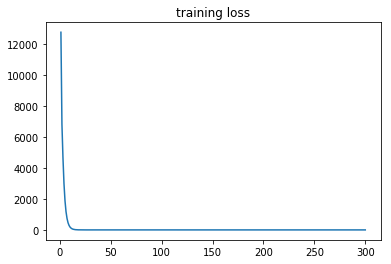

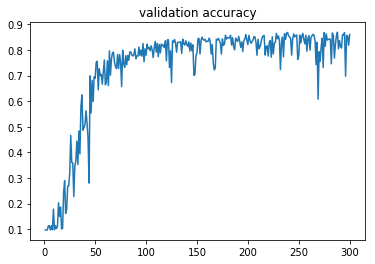

In [13]:
plt.figure()
plt.plot(np.arange(1, niter + 1), loss2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1, niter + 1), accuracy_test)
plt.title('validation accuracy')

### Plot $\|\mathbf{W}_i^{(t)} - \mathbf{W}_i^{(t-1)}\|_F + \|\mathbf{b}_i^{(t)} - \mathbf{b}_i^{(t-1)}\|$ for layers $i=1, \ldots, 11$ against epoch

Text(0.5,1,'Layer 11')

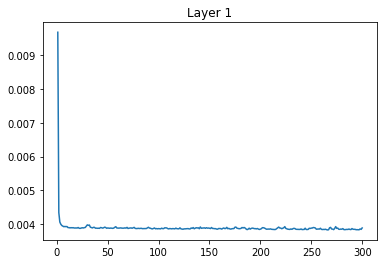

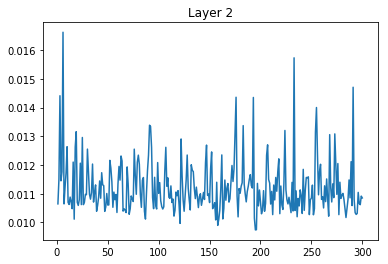

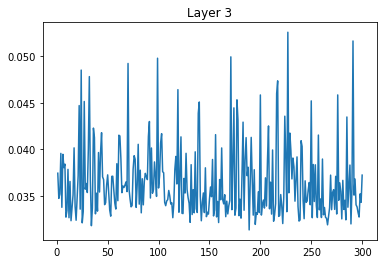

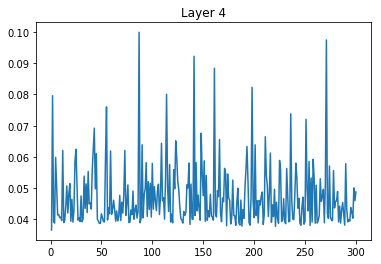

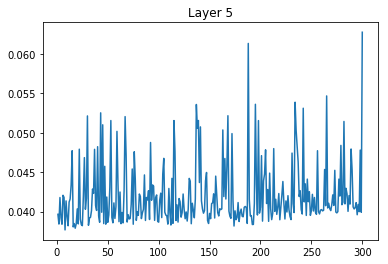

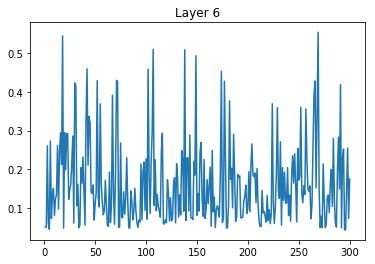

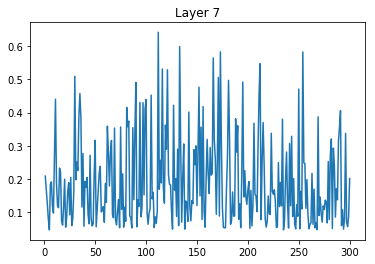

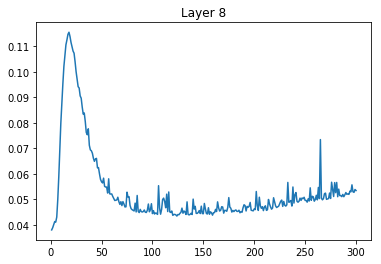

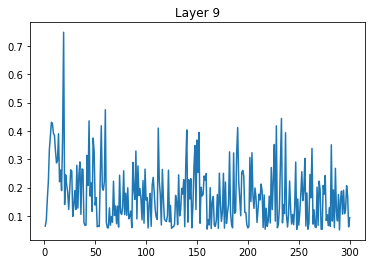

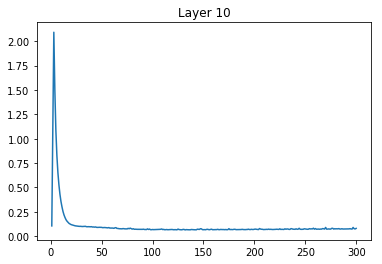

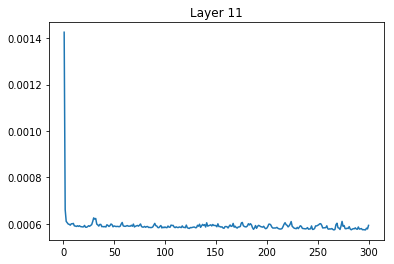

In [14]:
plt.figure()
plt.plot(np.arange(1, niter + 1), layer1)
plt.title('Layer 1')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer2)
plt.title('Layer 2')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer3)
plt.title('Layer 3')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer4)
plt.title('Layer 4')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer5)
plt.title('Layer 5')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer6)
plt.title('Layer 6')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer7)
plt.title('Layer 7')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer8)
plt.title('Layer 8')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer9)
plt.title('Layer 9')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer10)
plt.title('Layer 10')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer11)
plt.title('Layer 11')

### Plot $\|\mathbf{W}_i^{(t)} - \mathbf{W}_i^{(t-1)}\|_F/\|\mathbf{W}_i^{(t-1)}\|_F + \|\mathbf{b}_i^{(t)} - \mathbf{b}_i^{(t-1)}\|/\|\mathbf{b}_i^{(t-1)}\|$ for layers $i=1, \ldots, 11$ against epoch

Text(0.5,1,'Layer 11')

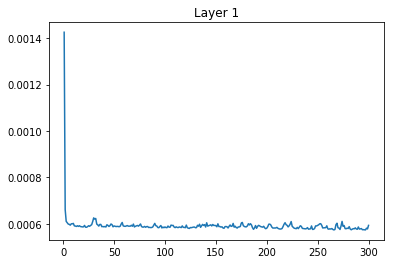

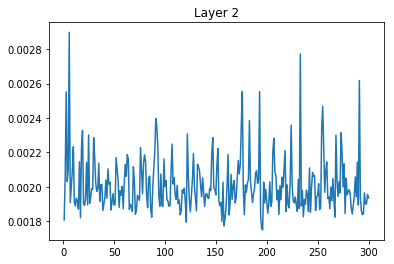

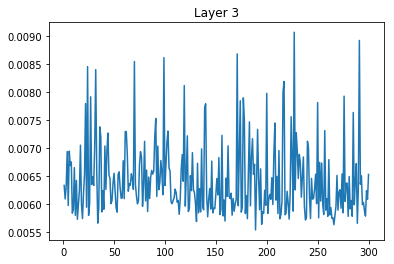

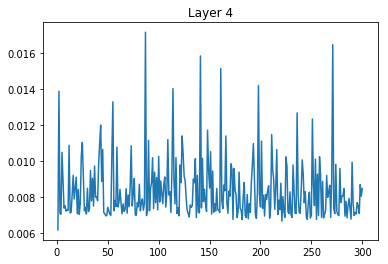

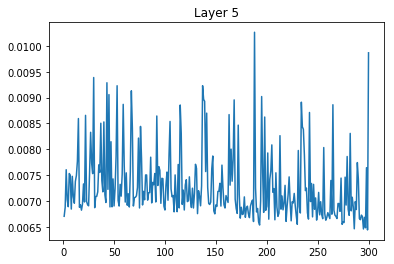

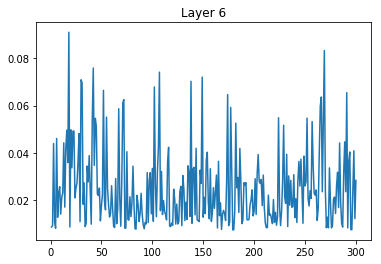

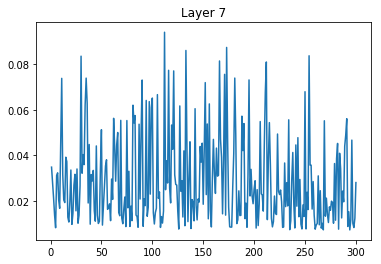

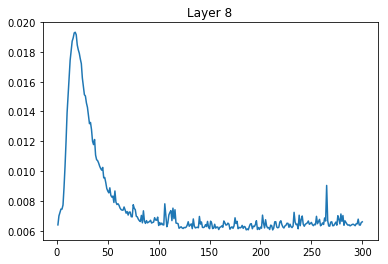

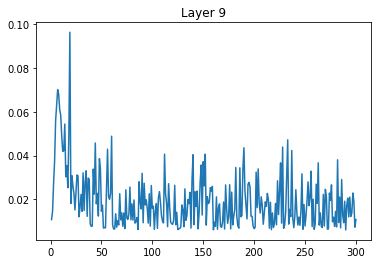

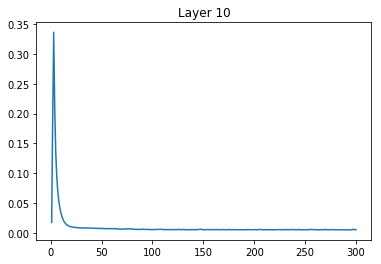

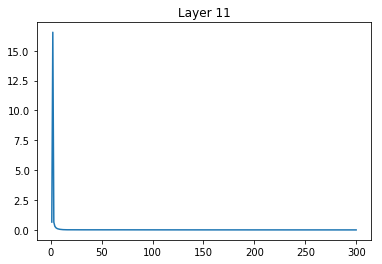

In [15]:
plt.figure()
plt.plot(np.arange(1, niter + 1), layer11)
plt.title('Layer 1')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer21)
plt.title('Layer 2')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer31)
plt.title('Layer 3')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer41)
plt.title('Layer 4')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer51)
plt.title('Layer 5')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer61)
plt.title('Layer 6')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer71)
plt.title('Layer 7')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer81)
plt.title('Layer 8')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer91)
plt.title('Layer 9')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer101)
plt.title('Layer 10')

plt.figure()
plt.plot(np.arange(1, niter + 1), layer111)
plt.title('Layer 11')

### Plot internal covariate shift (ICS) $\|\nabla_{\mathbf{W}_i}\mathcal{L}(\mathbf{W}_i^{(t)}) - \nabla_{\mathbf{W}_i}\mathcal{L}(\mathbf{W}_i^{(t-1)})\|_F$ against epoch

In [16]:
# plt.figure()
